# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: The Search for New Earths

This project analyses the data observed by the NASA Kepler space telescope searching for exoplanets using the transit technique.  
planets themselves do not emit light, but the stars that they orbit do. If said star is watched over several months or years, there may be a regular 'dimming' of the flux (the light intensity). This is evidence that there may be an orbiting body around the star; such a star could be considered to be a 'candidate' system.
NASA itself utilises python to interpret the data and has created PyKE, a library for data reduction to help with extraction and preprocessing of the light curve images, however this project analyses only FLUX data, not pictures.
Some of the machine learning techniques already been used by developers are 1-D CNN, XGBoosting, PCA.

## Getting Started
Loading the dataset

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
import scipy
import matplotlib.patches as mpatches
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import helper as hp
# Pretty display for notebooks
%matplotlib inline
print "Libraries imported successfully"

Libraries imported successfully


In [2]:
# Load the kepler training dataset
try:
    data = pd.read_csv(os.path.join("project_dataset", 'exoTrain.csv'),index_col=0)
    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

kepler dataset has 5087 samples with 3198 features each.


## Data Exploration
the author of the database labelled with 1 no exoplanet system and 2 exoplanet system

In [3]:
#create label array and drop it from features
labels = data.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
labels.replace(1,0, inplace=True)
labels.replace(2,1, inplace=True)
data.drop('LABEL',axis=1, inplace =True)

In [ ]:
# Display a description of the dataset
display(data.describe())

### Data Analysis on Exoplanet data
i will select the data from class 2 and explore it in more detail

In [ ]:
# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data[labels == 1], columns = data.keys()).reset_index(drop = True)
#print "Chosen samples of systems dataset:"
#display(samples.head())

### visualization of luminosity on time series
#### note
some system have strong drops in luminescence, this systems must have a big or close planet orbiting it, this makes this type of system easier to diferenciate from the non exo-systems, i will analyse more in details the ones where there is less clarity.

## normalisation
i will normalise the distribution of the data using the (Xi - mean) / std

In [18]:
from sklearn.preprocessing import RobustScaler
#scaler = RobustScaler().fit(data)
log_data = pd.DataFrame(normalize(data), columns = data.keys(), index = data.index)
#log_data = pd.DataFrame(scaler.transform(data), columns = data.keys(), index = data.index)
display(log_data[labels ==1].head())

,FLUX-1,FLUX-2,FLUX-3,FLUX-4,FLUX-5,FLUX-6,FLUX-7,FLUX-8,FLUX-9,FLUX-10,...,FLUX-3188,FLUX-3189,FLUX-3190,FLUX-3191,FLUX-3192,FLUX-3193,FLUX-3194,FLUX-3195,FLUX-3196,FLUX-3197
1,0.010309,0.009206,0.002208,-0.002964,-0.004345,-0.013699,-0.014849,-0.010575,-0.008775,-0.017594,...,-0.008575,-0.011220,-0.011220,0.002760,0.005335,0.010165,0.004319,0.006747,0.000558,-0.004343
2,-0.011373,-0.009896,-0.017124,-0.011727,-0.023200,-0.021299,-0.025318,-0.024961,-0.024563,-0.021465,...,-0.000959,-0.009422,-0.009422,-0.007281,-0.001422,0.000222,-0.003423,0.001890,0.004680,0.005830
3,0.033411,0.033617,0.032225,0.031170,0.028632,0.029231,0.029137,0.030510,0.027384,0.030384,...,-0.004497,0.000835,0.000835,-0.001875,-0.001310,0.000317,-0.000740,-0.001813,-0.004392,-0.006064
4,0.055889,0.059461,0.051752,0.051029,0.054386,0.053523,0.055172,0.053285,0.053475,0.055343,...,0.000977,-0.000638,-0.000638,0.005144,0.003428,-0.002169,-0.001501,-0.002963,-0.002970,0.002393
5,-0.048077,-0.048311,-0.048587,-0.047551,-0.045921,-0.044919,-0.043350,-0.044408,-0.042969,-0.042157,...,-0.025809,-0.017441,-0.017441,-0.015512,-0.019269,-0.019042,-0.017356,-0.016702,-0.017881,-0.022169


In [ ]:
fig = plt.figure(figsize=(20,40))
x = np.array(range(3197))
for i in range(3):
    ax = fig.add_subplot(13,3,i+1)
    ax.scatter(x,log_data.iloc[i,:])

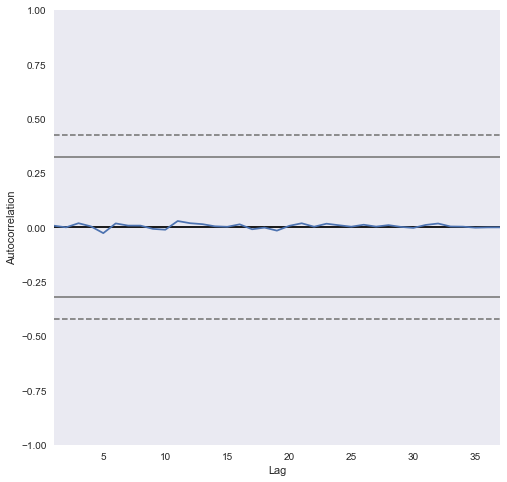

In [19]:
from pandas.tools.plotting import autocorrelation_plot
fig = plt.figure(figsize=(8,8))
autocorrelation_plot(log_data[:37])

In [20]:
# For each feature find the data points with extreme high or low values
indices = []
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = ( Q3 - Q1 )*1.5
    
    # Display the outliers
    #print "Data points considered outliers for the feature '{}':".format(feature)
    #display(data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))])
    indices.extend(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.tolist())

    
#look for indices that repeats at least twice
from collections import Counter
cnt = Counter()
for index in indices:
     cnt[index] += 1

In [21]:
OnePer = int(len(data['FLUX-1'])/100)
print "remove 1% of the outliers which is: {} ".format(OnePer)
print cnt.most_common(OnePer)

remove 1% of the outliers which is: 50 
[(4187, 488), (4911, 459), (4469, 439), (3248, 433), (1678, 425), (3659, 418), (3953, 402), (2843, 388), (3065, 388), (4444, 384), (731, 381), (623, 375), (5080, 375), (2022, 372), (495, 370), (1689, 368), (1799, 366), (422, 363), (879, 361), (1443, 359), (5020, 359), (1912, 358), (3305, 358), (3949, 356), (68, 353), (1643, 353), (4177, 353), (4828, 353), (4421, 351), (894, 350), (47, 349), (3967, 348), (2779, 345), (2399, 344), (3459, 344), (1068, 341), (1379, 341), (3596, 339), (2149, 337), (2692, 336), (3032, 336), (43, 335), (2927, 333), (1656, 332), (2561, 332), (3525, 331), (5003, 331), (143, 330), (1787, 328), (3306, 326)]


In [22]:
#plot the most common outlier
outliers = list(cnt.most_common(OnePer))
#fig = plt.figure(figsize=(20,40))
for i in range(OnePer):
    outliers[i] = outliers[i][0]
    #ax = fig.add_subplot(12,3,i+1)
    #plt.title(labels[outliers[i]])
    #ax.scatter(x,data.iloc[outliers[i],:])

In [23]:
#remove the 10 outliers
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
good_lables = labels.drop(labels.index[outliers]).reset_index(drop = True)

## class imbalance correction
at this point we are ready to apply correction for class imbalance

using SMOTETomek method combined with PCA at 12 features we have a recall of 20% on class 1
#### TODO: add data visualisation for class imbalance 

In [24]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio = 0.017,random_state =42,k_neighbors =2,kind =  'svm')
st = SMOTETomek(smote = sm, ratio= 0.017, random_state = 42)
X_resampled, y_resampled = st.fit_sample(good_data, good_lables)

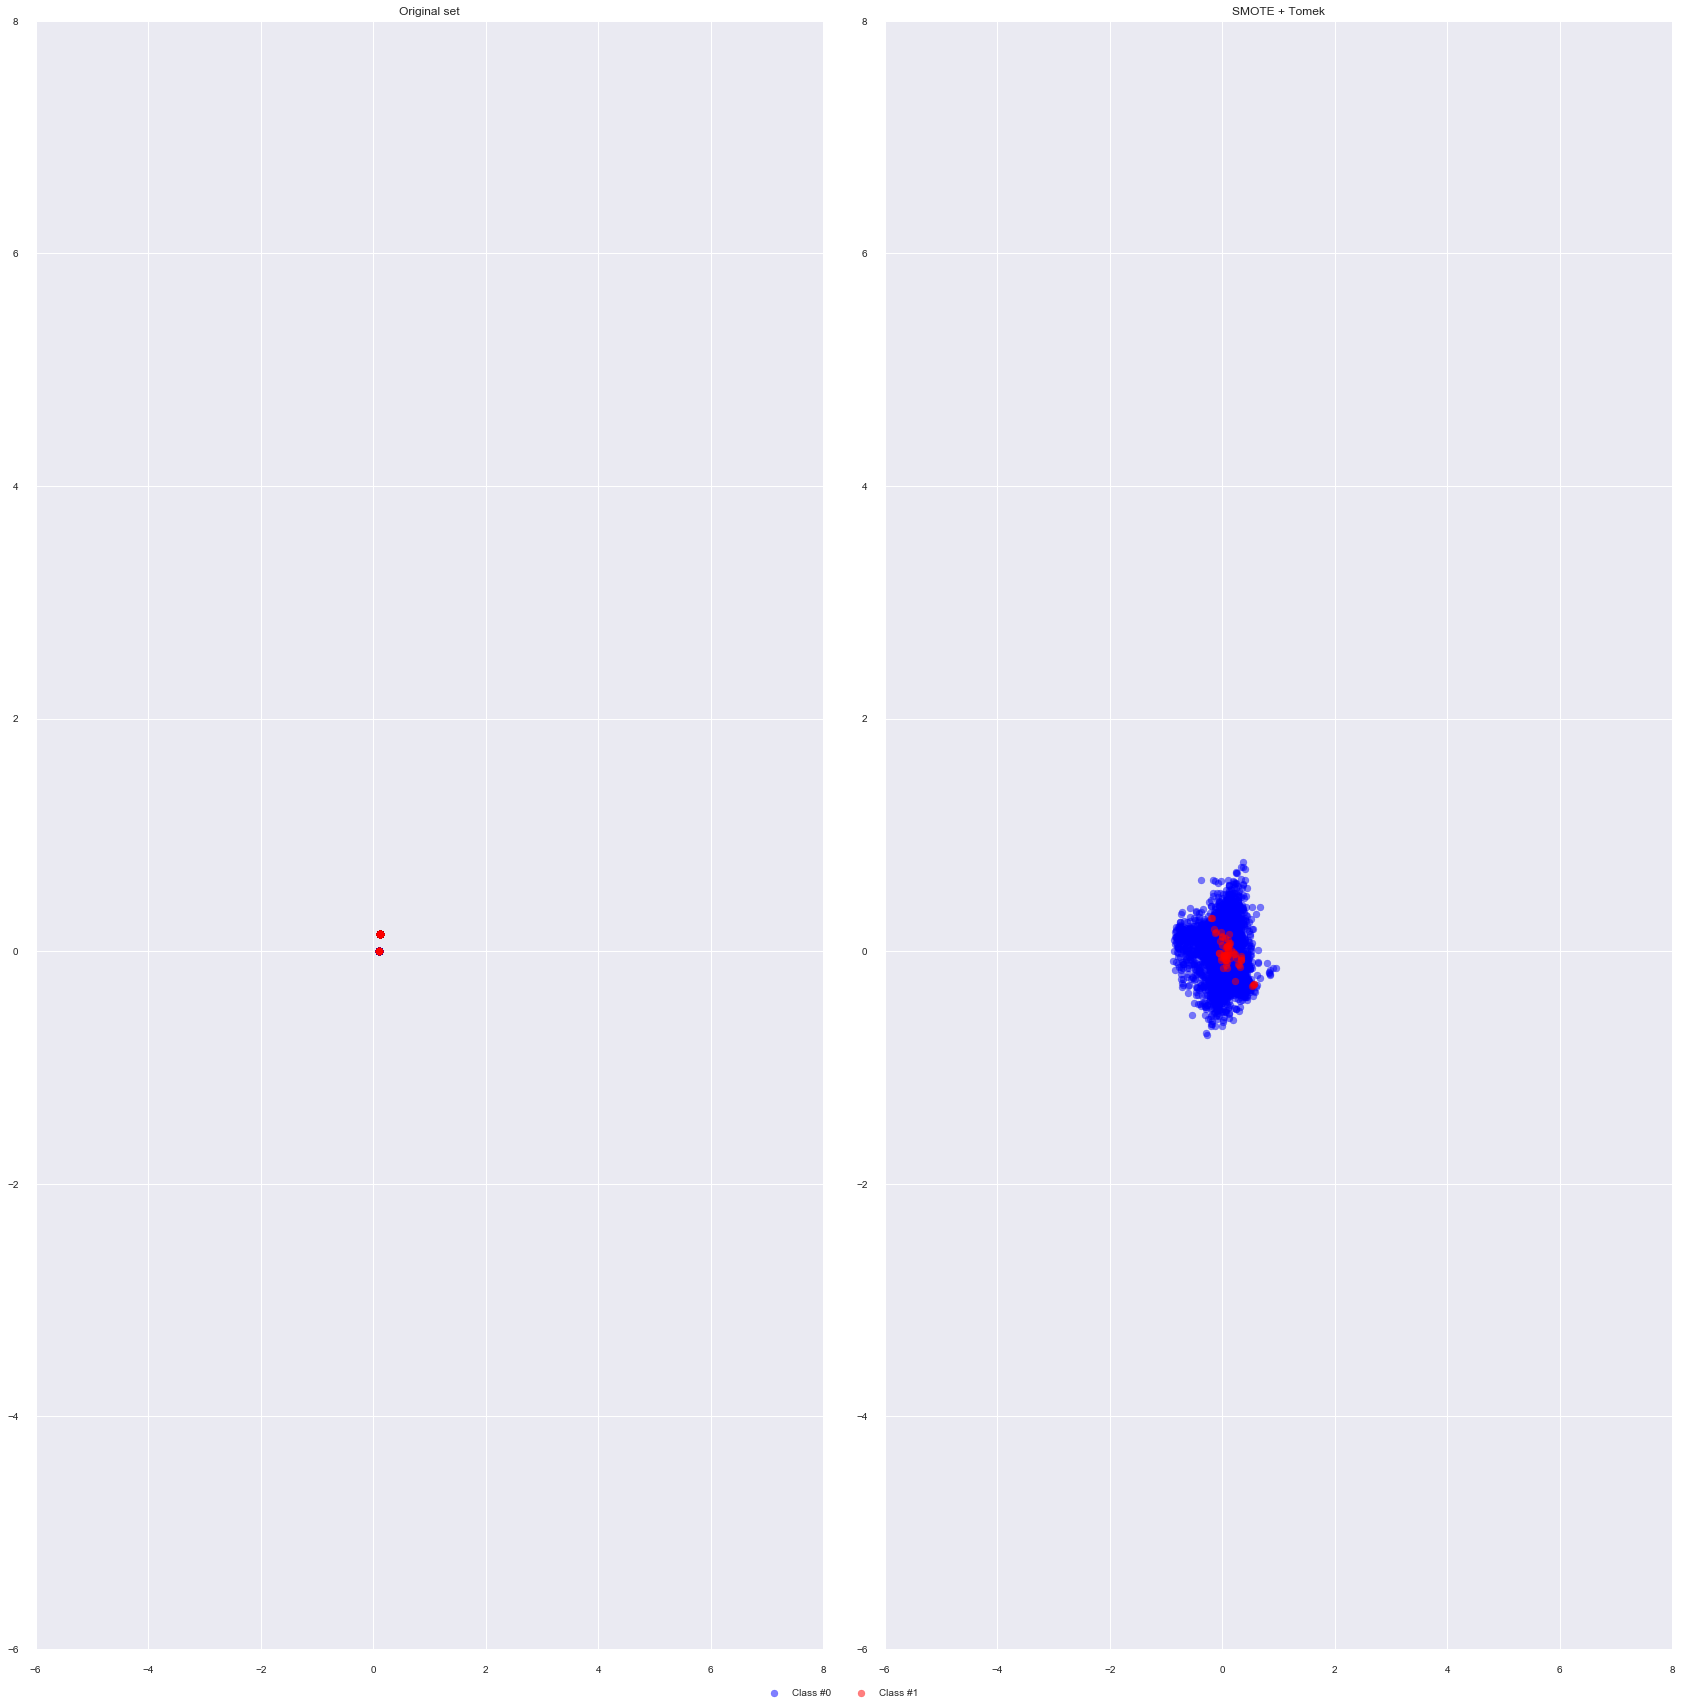

In [25]:
hp.vs_class_imbalance(good_data, good_lables,X_resampled, y_resampled)

In [26]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,stratify =y_resampled,  test_size=0.4, random_state=42)
#save data
pickle.dump((X_train, y_train), open('SmoteTomek-Train.p', 'wb'))
pickle.dump((X_test, y_test), open('SmoteTomek-Validation.p', 'wb'))

## Checkpoint
resampled data saved
## Feature Transformation
### application of PCA looking for best number of features
explained variance on training set
* Dimension 1     0.4829
* Dimension 2     0.8346
* Dimension 3     0.8847
* Dimension 4     0.9226
* Dimension 5     0.9438
* Dimension 6     0.9620
* Dimension 7     0.9772
* Dimension 8     0.9830
* Dimension 9     0.9855
* Dimension 10    0.9874

In [27]:
# Load the Preprocessed data
X_train, y_train = pickle.load(open('SmoteTomek-Train.p', mode='rb'))
X_val, y_val = pickle.load(open('SmoteTomek-Validation.p', mode='rb'))
# Load the Preprocessed data
#X_train, y_train = pickle.load(open('EasyEnsemble-Train.p', mode='rb'))
#X_val, y_val = pickle.load(open('EasyEnsemble-Validation.p', mode='rb'))

In [105]:
pca = PCA(n_components=100, svd_solver ='full',random_state = 42).fit(X_train)
#from sklearn.decomposition import KernelPCA
#pca = KernelPCA(n_components = 100, kernel='rbf', gamma =0.01).fit(X_train)
X_trainPCA = pca.transform(X_train)
X_testPCA = pca.transform(X_val)

### Visualize Data
since with 2 dimention we can describe 83.4% of the data we are able to plot a scatted of it

In [106]:
print sum(pca.explained_variance_ratio_ )
#print pca.get_params

0.66963369389


In [34]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    ''' 
    from sklearn.metrics import fbeta_score, accuracy_score
    results = {}
    
    #Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    results['train_time'] = end - start
        
    #Get the predictions on the test set,
    #then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta =1.5)
        
    #Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta =1.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

In [35]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j/3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j/3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j/3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j/3, j%3].set_xlabel("Training Set Size")
                ax[j/3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()
    


RandomForestClassifier trained on 607 samples.
RandomForestClassifier trained on 1214 samples.
RandomForestClassifier trained on 3036 samples.
GaussianNB trained on 607 samples.
GaussianNB trained on 1214 samples.
GaussianNB trained on 3036 samples.
GradientBoostingClassifier trained on 607 samples.
GradientBoostingClassifier trained on 1214 samples.
GradientBoostingClassifier trained on 3036 samples.


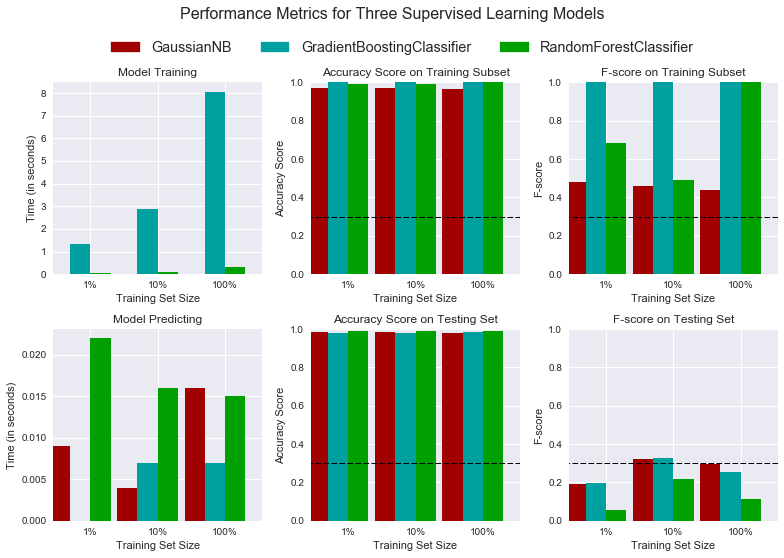

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

#Initialize the three models
clf_A = RandomForestClassifier(random_state = 42)
clf_B = GaussianNB()
clf_C = GradientBoostingClassifier(n_estimators = 100, max_depth= 7,min_impurity_split= 100000.0,random_state = 42)
tot_training = X_trainPCA.shape[0]

#Calculate the number of samples for 1%, 10%,100% of the training data
samples_1 =   int(tot_training * 0.2)
samples_10 =  int(tot_training * 0.4)
samples_100 = int(tot_training * 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_trainPCA, y_train, X_testPCA, y_val)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, 0.3, 0.3)

### Model Selection and optimisation


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [108]:
#from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced
y_pred = clf_B.predict(X_testPCA)
print classification_report_imbalanced(y_test, y_pred)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.32      0.99      0.51      0.27      2000
          1       0.26      0.32      0.99      0.29      0.51      0.24        25

avg / total       0.98      0.98      0.33      0.98      0.51      0.27      2025



In [72]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = fbeta_score(y_true, y_predict,beta =1.5) 
    # Return the score
    return score

In [70]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """    
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 42)

    #params dictionary for grid search
    ##test:
    ##learning_rate: (0.1,0.08,0.01,0.5)n_estimators:(50,100,180,200,250)max_depth(3,4,5,6,7,8,10)
    params = {'min_impurity_split': (1e05,1e-06)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(clf_C,params,scoring = scoring_fnc,cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

C:\Users\andre\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [73]:
# Fit the training data to the model using grid search
#use all training data
X_train_all = np.vstack([X_train,X_val])
y_train_all = np.concatenate((y_train,y_val),axis=0)
X_trainPCA = pca.transform(X_train_all)
clf = fit_model(X_trainPCA, y_train_all)
print 'operation completed'

operation completed


In [74]:
display(clf.get_params())
y_pred = clf.predict(X_testPCA)
print classification_report_imbalanced(y_test, y_pred)

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 100000.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      2000
          1       1.00      1.00      1.00      1.00      1.00      1.00        25

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      2025



## loading testing data
now load the test data and test on the classifier.

In [75]:
# Load the kepler dataset
Testdata = pd.read_csv(os.path.join("project_dataset", 'exoTest.csv'),index_col=0)
#    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
#except:
#    print "Dataset could not be loaded. Is the dataset missing?"

In [76]:
#create label array and drop it from features
testlabels = Testdata.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
testlabels.replace(1,0, inplace=True)
testlabels.replace(2,1, inplace=True)
Testdata.drop('LABEL',axis=1, inplace =True)

## evaluation of the result

In [77]:
from sklearn.metrics import confusion_matrix
X_test = pca.transform(Testdata)
y_pred = clf.predict(X_test)
print classification_report_imbalanced(testlabels, y_pred)
print confusion_matrix(testlabels, y_pred, labels = [0,1])

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.00      1.00      0.00      0.00       565
          1       0.00      0.00      1.00      0.00      0.00      0.00         5

avg / total       0.98      0.99      0.01      0.99      0.00      0.00       570

[[565   0]
 [  5   0]]
